# Pipeline accident cost prediction

**Objective: Cost study and cost prediction of a pipeline incident**

The database is listing all accidents reported in the USA from 2010 to 2017 with a wide range of qualitative and quantitative information such as pipeline type, location, operator ID, incurred cost for each incident. Amongst possible use cases of this data set, we are interested in predicting cost of an accident by using other feature variables available. Prior to modelling, some data retreatments are needed to improve the meaning of cost prediction and due to high number of NaN values in the dataset. We employ multiple models and compare their prediction accuracy to find what is the most suitable model to our objective.

The source of the data set: https://www.kaggle.com/usdot/pipeline-accidents

Steps in this notebook:
-	Variables selection to do cost predictions
-	Data visualization
-   Outliers identification and costs structure plots
-   New dataset for machine learning and correlation matrix
-	One-hot encoding & value replacement
-	Modelling and regression
-   Conclusion (Accuracy of predictions)

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib as plt
%matplotlib inline

# handle error messages
import warnings
warnings.filterwarnings("ignore")

## Data

In [3]:
path = './database.csv'
df = pd.read_csv(path,delimiter=',')
print(df.shape)
print(df.info())

(2795, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 48 columns):
Report Number                           2795 non-null int64
Supplemental Number                     2795 non-null int64
Accident Year                           2795 non-null int64
Accident Date/Time                      2795 non-null object
Operator ID                             2795 non-null int64
Operator Name                           2795 non-null object
Pipeline/Facility Name                  2674 non-null object
Pipeline Location                       2795 non-null object
Pipeline Type                           2777 non-null object
Liquid Type                             2795 non-null object
Liquid Subtype                          1349 non-null object
Liquid Name                             222 non-null object
Accident City                           2480 non-null object
Accident County                         2720 non-null object
Accident State                   

In [4]:
# Remove columns whose data is more than 90% NaNs
mask = df.apply(lambda x: x.isna().sum()/len(x) < 0.9)
mask = [mask[c] for c in range(len(mask))]
df_reduced = df.loc[:, mask]

# Number of columns reduced from 48 to 35
print(df_reduced.shape)
df_reduced.T

(2795, 35)


,0,1,2,3,4,5,6,7,8,9,...,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794
Report Number,20100016,20100254,20100038,20100260,20100030,20100021,20110036,20100255,20100261,20100024,...,20170020,20170022,20170021,20170023,20170026,20170015,20170028,20170027,20170024,20170025
Supplemental Number,17305,17331,17747,18574,16276,17161,18052,18584,18050,18390,...,22026,22029,22027,22030,22044,22020,22046,22045,22032,22040
Accident Year,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2016,2016,2016,2016,2016,2016,2016,2016,2017,2017
Accident Date/Time,1/1/2010 7:15 AM,1/4/2010 8:30 AM,1/5/2010 10:30 AM,1/6/2010 7:30 PM,1/7/2010 1:00 PM,1/8/2010 11:38 PM,1/9/2010 12:15 AM,1/9/2010 1:12 AM,1/10/2010 7:46 PM,1/11/2010 2:30 PM,...,12/21/2016 11:40 AM,12/22/2016 9:25 PM,12/23/2016 3:00 PM,12/24/2016 9:35 AM,12/26/2016 7:20 AM,12/27/2016 8:40 AM,12/28/2016 4:20 PM,12/29/2016 6:40 AM,1/3/2017 10:00 AM,1/9/2017 7:40 AM
Operator ID,32109,15786,20160,11169,300,11169,26041,12624,26041,31684,...,32147,32080,30829,31684,32011,32334,4906,39145,32147,30829
Operator Name,ONEOK NGL PIPELINE LP,PORTLAND PIPELINE CORP,"PETROLOGISTICS OLEFINS, LLC","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","PLAINS PIPELINE, L.P.","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","KINDER MORGAN LIQUID TERMINALS, LLC",MOBIL CORP,"KINDER MORGAN LIQUID TERMINALS, LLC",CONOCOPHILLIPS,...,MARATHON PIPE LINE LLC,"CCPS TRANSPORTATION, LLC",ENTERPRISE CRUDE PIPELINE LLC,PHILLIPS 66 PIPELINE LLC,"HOLLY ENERGY PARTNERS - OPERATING, L.P.",TC OIL PIPELINE OPERATIONS INC,EXXONMOBIL PIPELINE CO,ENBRIDGE STORAGE (CUSHING) L.L.C.,MARATHON PIPE LINE LLC,ENTERPRISE CRUDE PIPELINE LLC
Pipeline/Facility Name,KINDER MORGAN JCT,24-INCH MAIN LINE,NaN,SUPERIOR TERMINAL,RED RIVER EAST,NaN,NaN,HULL STATION,NaN,TANK 1501,...,ELWOOD STATION,LINE 59 KEY STATION,ECHO MANIFOLD,"NT-90, PREDO TO CARSON",RUSSELL STATION,KEYSTONE,BRRF - CHOCTAW ETHANE/PROPANE MIX SYSTEM,CUSHING CENTRAL TERMINAL,MIDLAND STATION,MARSHALL STATION
Pipeline Location,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,...,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE
Pipeline Type,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,UNDERGROUND,UNDERGROUND,TANK,ABOVEGROUND,ABOVEGROUND,TANK,...,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,TANK,UNDERGROUND,ABOVEGROUND
Liquid Type,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,CRUDE OIL,CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",...,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",CRUDE OIL


- Among these, interesting explanatory variables Xs could be: Operator ID, Pipeline Type, Liquid Type, cause subcategory, Net Loss (Barrels), Liquid Ignition, Liquid Explosion, Shutdown duration (created variable). ==> 8 explanatory variables

- Injuries and Fatalities as well as columns relating to location of accidents won't be considered in our analysis because considered as meaningless for cost prediction. Some others are excluded because of high nans values proportion: 
Supplemental Number, Liquid Name, Pipeline Location (because imbalanced data), Accident City, Accident County, Accident Latitude, Accident Longitude, Public Evacuations,...

'Shutdown duration' column creation

In [5]:
# Shutdown duration column creation
# Problem : only 1341 values
df_reduced['Shutdown Duration'] = (pd.to_datetime(df_reduced['Restart Date/Time']) - pd.to_datetime(df_reduced['Shutdown Date/Time']))\
.astype('timedelta64[h]')
df = df_reduced.fillna({'Shutdown Duration': 0}) # change nans into 0

# Statistics of Shutdown Duration
print(df['Shutdown Duration'].describe()) # hours

count     2795.000000
mean        90.337746
std        626.831444
min          0.000000
25%          0.000000
50%          0.000000
75%         18.000000
max      16746.000000
Name: Shutdown Duration, dtype: float64


In [6]:
'''
Notice: Net loss (Barrels) discloses some non-integer figures (0,89 ; 4,16 ; ...)
        Shutdown Duration has 1341 values only
'''
print(df.shape)
df.T

(2795, 36)


,0,1,2,3,4,5,6,7,8,9,...,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794
Report Number,20100016,20100254,20100038,20100260,20100030,20100021,20110036,20100255,20100261,20100024,...,20170020,20170022,20170021,20170023,20170026,20170015,20170028,20170027,20170024,20170025
Supplemental Number,17305,17331,17747,18574,16276,17161,18052,18584,18050,18390,...,22026,22029,22027,22030,22044,22020,22046,22045,22032,22040
Accident Year,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2016,2016,2016,2016,2016,2016,2016,2016,2017,2017
Accident Date/Time,1/1/2010 7:15 AM,1/4/2010 8:30 AM,1/5/2010 10:30 AM,1/6/2010 7:30 PM,1/7/2010 1:00 PM,1/8/2010 11:38 PM,1/9/2010 12:15 AM,1/9/2010 1:12 AM,1/10/2010 7:46 PM,1/11/2010 2:30 PM,...,12/21/2016 11:40 AM,12/22/2016 9:25 PM,12/23/2016 3:00 PM,12/24/2016 9:35 AM,12/26/2016 7:20 AM,12/27/2016 8:40 AM,12/28/2016 4:20 PM,12/29/2016 6:40 AM,1/3/2017 10:00 AM,1/9/2017 7:40 AM
Operator ID,32109,15786,20160,11169,300,11169,26041,12624,26041,31684,...,32147,32080,30829,31684,32011,32334,4906,39145,32147,30829
Operator Name,ONEOK NGL PIPELINE LP,PORTLAND PIPELINE CORP,"PETROLOGISTICS OLEFINS, LLC","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","PLAINS PIPELINE, L.P.","ENBRIDGE ENERGY, LIMITED PARTNERSHIP","KINDER MORGAN LIQUID TERMINALS, LLC",MOBIL CORP,"KINDER MORGAN LIQUID TERMINALS, LLC",CONOCOPHILLIPS,...,MARATHON PIPE LINE LLC,"CCPS TRANSPORTATION, LLC",ENTERPRISE CRUDE PIPELINE LLC,PHILLIPS 66 PIPELINE LLC,"HOLLY ENERGY PARTNERS - OPERATING, L.P.",TC OIL PIPELINE OPERATIONS INC,EXXONMOBIL PIPELINE CO,ENBRIDGE STORAGE (CUSHING) L.L.C.,MARATHON PIPE LINE LLC,ENTERPRISE CRUDE PIPELINE LLC
Pipeline/Facility Name,KINDER MORGAN JCT,24-INCH MAIN LINE,NaN,SUPERIOR TERMINAL,RED RIVER EAST,NaN,NaN,HULL STATION,NaN,TANK 1501,...,ELWOOD STATION,LINE 59 KEY STATION,ECHO MANIFOLD,"NT-90, PREDO TO CARSON",RUSSELL STATION,KEYSTONE,BRRF - CHOCTAW ETHANE/PROPANE MIX SYSTEM,CUSHING CENTRAL TERMINAL,MIDLAND STATION,MARSHALL STATION
Pipeline Location,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,...,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE,ONSHORE
Pipeline Type,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,UNDERGROUND,UNDERGROUND,TANK,ABOVEGROUND,ABOVEGROUND,TANK,...,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,ABOVEGROUND,UNDERGROUND,TANK,UNDERGROUND,ABOVEGROUND
Liquid Type,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,CRUDE OIL,CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...","REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",...,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,CRUDE OIL,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",CRUDE OIL,"REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LI...",CRUDE OIL


### Data visualization

Top 10 largest accidents in terms of All Costs

In [7]:
print(df.loc[:,['All Costs','Operator Name']].sort_values(by='All Costs', ascending=False).head(10))

# Statistics of All Costs
print(df['All Costs'].describe())

      All Costs                         Operator Name
194   840526118  ENBRIDGE ENERGY, LIMITED PARTNERSHIP
2103  142931884                 PLAINS PIPELINE, L.P.
523   135000000                EXXONMOBIL PIPELINE CO
1173   91300000             MOBIL  PIPE  LINE COMPANY
2675   66234072                  COLONIAL PIPELINE CO
241    47393566  ENBRIDGE ENERGY, LIMITED PARTNERSHIP
457    35728903                MARATHON PIPE LINE LLC
160    32233740                  CHEVRON PIPE LINE CO
133    28938000           ALYESKA PIPELINE SERVICE CO
1833   24323483    CHEVRON PETROCHEMICAL PIPELINE LLC
count    2.795000e+03
mean     8.340332e+05
std      1.657830e+07
min      0.000000e+00
25%      5.039500e+03
50%      2.312900e+04
75%      1.172325e+05
max      8.405261e+08
Name: All Costs, dtype: float64


Top 10 operators in terms of the number of incidents

In [8]:
df_count = df.groupby('Operator ID').size().nlargest(10).reset_index()
df_count = df_count.rename(columns={0:'Number of Incidents'})
name = []
for id in df_count['Operator ID']:
    name.append(" or ".join(df['Operator Name'].loc[df['Operator ID'] == id].unique()))
df_name = pd.DataFrame({'Operator Name': name})
pd.concat([df_count, df_name], axis=1).ix[:,['Operator Name','Operator ID','Number of Incidents']]

,Operator Name,Operator ID,Number of Incidents
0,"TEPPCO CRUDE PIPELINE, LLC or ENTERPRISE CRUDE...",30829,201
1,SUNOCO PIPELINE L.P.,18718,180
2,"PLAINS PIPELINE, L.P.",300,156
3,ENTERPRISE PRODUCTS OPERATING LLC,31618,155
4,"MAGELLAN PIPELINE COMPANY, LP",22610,140
5,COLONIAL PIPELINE CO,2552,136
6,"BUCKEYE PARTNERS, LP",1845,115
7,CONOCOPHILLIPS or PHILLIPS 66 PIPELINE LLC,31684,114
8,"KINDER MORGAN LIQUID TERMINALS, LLC",26041,87
9,MARATHON PIPE LINE LLC,32147,87


In [9]:
print(pd.crosstab(df['Liquid Ignition'], df['Liquid Explosion']))

Liquid Explosion    NO  YES
Liquid Ignition            
NO                2700    0
YES                 80   15


In [10]:
print("Number of distinct Operator ID:", len(df['Operator ID'].unique()))
print("Number of distinct Operator Name:", len(df['Operator Name'].unique()))

Number of distinct Operator ID: 213
Number of distinct Operator Name: 229


Some Operator IDs have multiple Operator Names, probably due to M&A activities, etc.

In [11]:
df['Cause Category'].value_counts(), df['Cause Category'].describe()

(MATERIAL/WELD/EQUIP FAILURE    1435
 CORROSION                       592
 INCORRECT OPERATION             378
 ALL OTHER CAUSES                118
 NATURAL FORCE DAMAGE            118
 EXCAVATION DAMAGE                97
 OTHER OUTSIDE FORCE DAMAGE       57
 Name: Cause Category, dtype: int64, count                            2795
 unique                              7
 top       MATERIAL/WELD/EQUIP FAILURE
 freq                             1435
 Name: Cause Category, dtype: object)

In [12]:
df["Pipeline Type"].value_counts(), df['Pipeline Type'].describe()

(ABOVEGROUND        1475
 UNDERGROUND         985
 TANK                301
 TRANSITION AREA      16
 Name: Pipeline Type, dtype: int64, count            2777
 unique              4
 top       ABOVEGROUND
 freq             1475
 Name: Pipeline Type, dtype: object)

In [13]:
df["Pipeline Location"].value_counts()

ONSHORE     2777
OFFSHORE      18
Name: Pipeline Location, dtype: int64

In [14]:
df["Liquid Type"].value_counts(), df["Liquid Type"].describe()

(CRUDE OIL                                               1398
 REFINED AND/OR PETROLEUM PRODUCT (NON-HVL), LIQUID       939
 HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS               418
 CO2 (CARBON DIOXIDE)                                      38
 BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)       2
 Name: Liquid Type, dtype: int64, count          2795
 unique            5
 top       CRUDE OIL
 freq           1398
 Name: Liquid Type, dtype: object)

Majority of oil transportation: 1398 + 939

In [15]:
print(df.groupby(['Accident Year'])['All Costs'].mean())
print(df.groupby(['Accident Year'])['All Costs'].count())

Accident Year
2010    3.071983e+06
2011    7.928306e+05
2012    3.968509e+05
2013    6.945774e+05
2014    2.900540e+05
2015    5.491256e+05
2016    4.172569e+05
2017    4.361400e+04
Name: All Costs, dtype: float64
Accident Year
2010    350
2011    345
2012    366
2013    401
2014    454
2015    462
2016    415
2017      2
Name: All Costs, dtype: int64


Number of accident relatively stable yoy; 2017 is not reprensentative with only 2 reports

In [16]:
print(df.groupby(['Liquid Ignition'])['All Costs'].mean())
print(df.groupby(['Liquid Explosion'])['All Costs'].mean())
print(df.groupby(['Liquid Ignition'])['All Costs'].max())
print(df.groupby(['Liquid Explosion'])['All Costs'].max())

Liquid Ignition
NO     842947.114444
YES    580691.726316
Name: All Costs, dtype: float64
Liquid Explosion
NO     8.324311e+05
YES    1.130972e+06
Name: All Costs, dtype: float64
Liquid Ignition
NO     840526118
YES     10262149
Name: All Costs, dtype: int64
Liquid Explosion
NO     840526118
YES      6910591
Name: All Costs, dtype: int64


Ignition or explosion of a liquid seems not lead to higher costs 

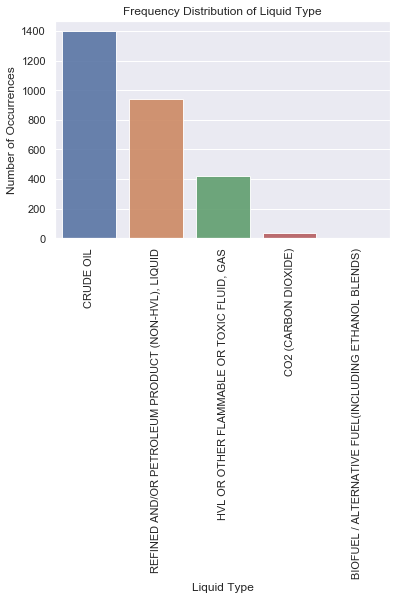

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
Liquid_Type_count = df['Liquid Type'].value_counts()
sns.set(style="darkgrid")
sns.barplot(Liquid_Type_count.index, Liquid_Type_count.values, alpha=0.9, errwidth=0.1)
plt.title('Frequency Distribution of Liquid Type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Liquid Type', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Text(0.5,1,'Pipeline Type')

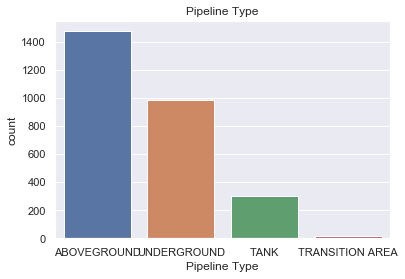

In [18]:
sns.countplot(df['Pipeline Type'])
plt.title('Pipeline Type')

Text(0.5,1,'Total costs per Pipeline Type')

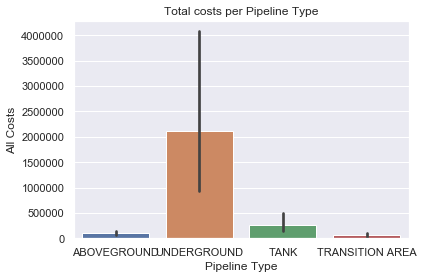

In [19]:
df_PipeLine_Type_All_Cost = df[['Pipeline Type','All Costs']]
sns.barplot(x='Pipeline Type', y="All Costs",  data=df_PipeLine_Type_All_Cost)
plt.title('Total costs per Pipeline Type')

Underground pipeline type rank second in number of accident but rank first in terms of cost, far ahead of other types. Black error bars are confidence intervals for each type of pipeline. If there are outliers, they stand in underground pipeline category

Text(0.5,1,'# Barrels Lost')

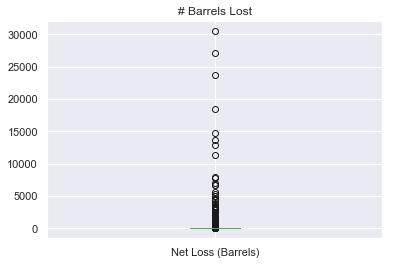

In [20]:
df.boxplot(column='Net Loss (Barrels)')
plt.title('# Barrels Lost')

### Outliers identification and costs structure plots

(2795, 36)


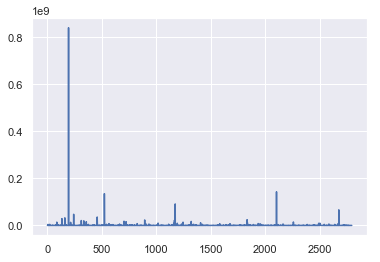

In [21]:
df['All Costs'].plot()
print(df.shape)

5 outliers identified as per this plot

Mean of accident costs is less than a million dollar. Lets focus on accident cost structure of top 25 (except outlier #1 for plot scale reason):

Text(0.5,0,'Index')

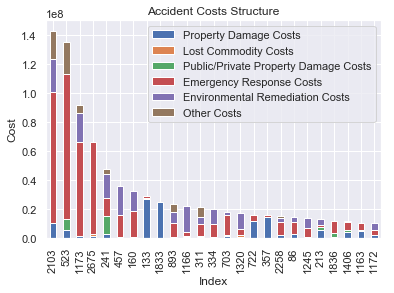

In [22]:
b = df['All Costs'].sort_values(ascending=False) [:30]
top25 = df.iloc[b.index[1:26], 28:-2]
top25.plot.bar(stacked=True)
plt.title('Accident Costs Structure')
plt.ylabel('Cost', fontsize=12)
plt.xlabel('Index', fontsize=12)

Emergency Response Costs represent the major part of costs structure of top 25 accidents, followed by Environmental remediation costs. Accident 1 is excluded of this graph for scaling matter; its' main costs were Environmental Remediation Costs and Emergency Response Costs respectively.

Sum of costs categories of all accidents:

In [23]:
print('Property Damage Costs:                ', "{:,}".format(df['Property Damage Costs'].sum()))
print('Environmental Remediation Costs:      ', "{:,}".format(df['Environmental Remediation Costs'].sum()))
print('Emergency Response Costs:             ', "{:,}".format(df['Emergency Response Costs'].sum()))
print('Lost Commodity Costs:                 ', "{:,}".format(df['Lost Commodity Costs'].sum()))
print('Public/Private Property Damage Costs: ', "{:,}".format(df['Public/Private Property Damage Costs'].sum()))
print('All Costs:                            ', "{:,}".format(df['All Costs'].sum()))

Property Damage Costs:                 313,081,992.0
Environmental Remediation Costs:       1,011,149,910.0
Emergency Response Costs:              814,084,371.0
Lost Commodity Costs:                  27,366,589.0
Public/Private Property Damage Costs:  69,964,627.0
All Costs:                             2,331,122,923


The 3 main costs categories are Environmental Remediation Costs, Emergency Response Costs and Property Damage Costs.

## New dataset for machine learning and correlation matrix

[Note] Try to use the maximum number of columns

### Column selection

In [24]:
# Select columns to be used for prediction
s = pd.Series([34,2,4,7,8,9,13,14,15,16,22,23,21,35])

# Highlight the selected columns
for col in range(len(df.columns)):
    if col in list(s):
        print("\033[31m" + str(col), df.columns[col] + "\033[0m")
    else:
        print(col, df.columns[col])

0 Report Number
1 Supplemental Number
2 Accident Year
3 Accident Date/Time
4 Operator ID
5 Operator Name
6 Pipeline/Facility Name
7 Pipeline Location
8 Pipeline Type
9 Liquid Type
10 Liquid Subtype
11 Accident City
12 Accident County
13 Accident State
14 Accident Latitude
15 Accident Longitude
16 Cause Category
17 Cause Subcategory
18 Unintentional Release (Barrels)
19 Intentional Release (Barrels)
20 Liquid Recovery (Barrels)
21 Net Loss (Barrels)
22 Liquid Ignition
23 Liquid Explosion
24 Pipeline Shutdown
25 Shutdown Date/Time
26 Restart Date/Time
27 Public Evacuations
28 Property Damage Costs
29 Lost Commodity Costs
30 Public/Private Property Damage Costs
31 Emergency Response Costs
32 Environmental Remediation Costs
33 Other Costs
34 All Costs
35 Shutdown Duration


In [25]:
df_selected = df[df.columns[s[:,]]].copy()
print(df_selected.shape)

(2795, 14)


In [26]:
# There are 18 NaNs in Pipeline Type column
print('pipeline type nans: ', df_selected["Pipeline Type"].isna().sum())

# All of those pipelines are located offshore 
print(df_selected['Pipeline Location'][df_selected["Pipeline Type"].isna()])
print(df_selected["Pipeline Location"].value_counts())

# So We replace Pipeline Type = NaN with 'Offshore'
df_selected["Pipeline Type"][df_selected["Pipeline Type"].isna()]='OFFSHORE'
df_selected["Pipeline Type"].value_counts()

# And we delete the column Pipeline location
df_selected2 = df_selected.drop(columns=['Pipeline Location'])

pipeline type nans:  18
53      OFFSHORE
75      OFFSHORE
174     OFFSHORE
233     OFFSHORE
375     OFFSHORE
503     OFFSHORE
594     OFFSHORE
944     OFFSHORE
983     OFFSHORE
999     OFFSHORE
1290    OFFSHORE
1665    OFFSHORE
1733    OFFSHORE
1762    OFFSHORE
2039    OFFSHORE
2267    OFFSHORE
2340    OFFSHORE
2349    OFFSHORE
Name: Pipeline Location, dtype: object
ONSHORE     2777
OFFSHORE      18
Name: Pipeline Location, dtype: int64


Because of some relatively high values in costs to predict (Y variable) compared to it's mean, we create a 'Log All Cost' column to reduce extrem values and also increase correlation with explanatory variables

count    2795.000000
mean       10.006837
std         2.629996
min         0.000000
25%         8.525062
50%        10.048843
75%        11.671913
max        20.549539
Name: Log All Costs, dtype: float64


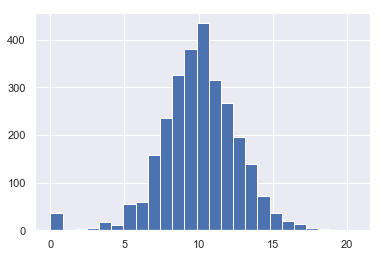

In [27]:
# Take logarithm of All Cost
LogAllCost = np.log(df_selected2['All Costs'])
LogAllCost = LogAllCost.replace([np.inf, -np.inf], np.nan).fillna(0)  # Replace -inf with 0
df_selected2['Log All Costs'] = LogAllCost

print(df_selected2['Log All Costs'].describe())
df_selected2['Log All Costs'].hist(bins=25)

In [28]:
print(df_selected2.shape)
df_selected2.head()

(2795, 14)


,All Costs,Accident Year,Operator ID,Pipeline Type,Liquid Type,Accident State,Accident Latitude,Accident Longitude,Cause Category,Liquid Ignition,Liquid Explosion,Net Loss (Barrels),Shutdown Duration,Log All Costs
0,1627,2010,32109,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",KS,38.67070,-97.78123,INCORRECT OPERATION,NO,NO,21.0,0.0,7.394493
1,4008,2010,15786,ABOVEGROUND,CRUDE OIL,ME,43.94028,-70.49336,MATERIAL/WELD/EQUIP FAILURE,NO,NO,0.0,0.0,8.296048
2,200,2010,20160,ABOVEGROUND,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",LA,30.18240,-93.35240,MATERIAL/WELD/EQUIP FAILURE,NO,NO,2.0,0.0,5.298317
3,11540,2010,11169,UNDERGROUND,CRUDE OIL,WI,46.68930,-92.06120,NATURAL FORCE DAMAGE,NO,NO,0.0,0.0,9.353575
4,29650,2010,300,UNDERGROUND,CRUDE OIL,TX,33.58266,-96.64881,EXCAVATION DAMAGE,NO,NO,2.0,0.0,10.297217


We have some categorical variables
Operator ID will increase significantly the dimensionality after One-hot encoding

In [29]:
df_selected2.cov() # Covariance matrix is not easily readable

,All Costs,Accident Year,Operator ID,Accident Latitude,Accident Longitude,Net Loss (Barrels),Shutdown Duration,Log All Costs
All Costs,2.748400e+14,-1.144180e+06,-6.160399e+09,3.315894e+06,1.326289e+06,1.216508e+09,6.666732e+08,6.474402e+06
Accident Year,-1.144180e+06,3.889186e+00,2.380026e+03,-5.218795e-01,-5.867873e-01,-1.562249e+01,-2.381257e+01,-6.814515e-02
Operator ID,-6.160399e+09,2.380026e+03,1.545291e+08,-5.718499e+03,-2.146652e+04,5.834308e+05,3.108264e+04,-2.738499e+03
Accident Latitude,3.315894e+06,-5.218795e-01,-5.718499e+03,3.195188e+01,-7.461077e-01,-1.181240e+01,-8.732440e+01,1.038993e+00
Accident Longitude,1.326289e+06,-5.867873e-01,-2.146652e+04,-7.461077e-01,1.519902e+02,2.109175e+02,7.989032e+01,8.272245e-01
Net Loss (Barrels),1.216508e+09,-1.562249e+01,5.834308e+05,-1.181240e+01,2.109175e+02,1.404271e+06,4.949745e+04,4.871775e+02
Shutdown Duration,6.666732e+08,-2.381257e+01,3.108264e+04,-8.732440e+01,7.989032e+01,4.949745e+04,3.929177e+05,2.618888e+02
Log All Costs,6.474402e+06,-6.814515e-02,-2.738499e+03,1.038993e+00,8.272245e-01,4.871775e+02,2.618888e+02,6.916880e+00


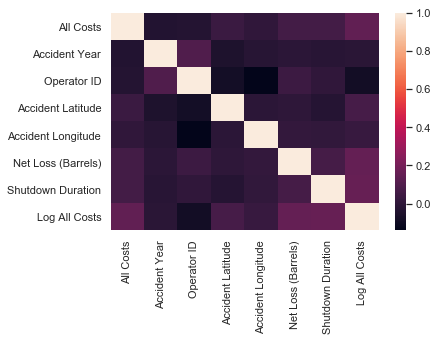

In [30]:
corr = df_selected2.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

'Log All Costs' are slightly correlated to Net loss (Barrels) and to shutdow Duration, but significantly more than 'All costs'. No strong correlation can be identified among the quantitative variables. We have at least orthogonality but we expect high error rate in our prediction model and/or weak R² if the regression is made only on these quantitative variables.

Increasing number of outliers and exclude them from dataset tends to strengthen correlation.

In [31]:
newdf = df_selected2.copy()

### One-hot encoding & Value replacement

In [32]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 14 columns):
All Costs             2795 non-null int64
Accident Year         2795 non-null int64
Operator ID           2795 non-null int64
Pipeline Type         2795 non-null object
Liquid Type           2795 non-null object
Accident State        2783 non-null object
Accident Latitude     2795 non-null float64
Accident Longitude    2795 non-null float64
Cause Category        2795 non-null object
Liquid Ignition       2795 non-null object
Liquid Explosion      2795 non-null object
Net Loss (Barrels)    2795 non-null float64
Shutdown Duration     2795 non-null float64
Log All Costs         2795 non-null float64
dtypes: float64(5), int64(3), object(6)
memory usage: 305.8+ KB


In [33]:
# Extract names of the categorical columns
categorical_columns = [col for col in newdf.columns if newdf[col].dtype == 'object']
# Add Operator ID column manually
categorical_columns.append('Operator ID')
categorical_columns

['Pipeline Type',
 'Liquid Type',
 'Accident State',
 'Cause Category',
 'Liquid Ignition',
 'Liquid Explosion',
 'Operator ID']

In [34]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

# Loop for one-hot encoding
for col in categorical_columns:
    dum = pd.get_dummies(newdf[col], prefix=col, drop_first=True)
    newdf = pd.concat([newdf, dum], axis=1)
    newdf = newdf.drop([col], axis=1)

print(newdf.shape)
newdf.T

(2795, 280)


,0,1,2,3,4,5,6,7,8,9,...,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794
All Costs,1627.000000,4008.000000,200.000000,11540.000000,29650.000000,4.194715e+06,70400.000000,413.000000,40336.0000,30050.000000,...,66041.000000,47047.000000,65075.000000,258510.000000,13120.000000,61015.000000,105400.000000,15050.000000,41428.000000,45800.000000
Accident Year,2010.000000,2010.000000,2010.000000,2010.000000,2010.000000,2.010000e+03,2010.000000,2010.000000,2010.0000,2010.000000,...,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2017.000000,2017.000000
Accident Latitude,38.670700,43.940280,30.182400,46.689300,33.582660,4.899555e+01,29.430500,30.085330,29.4305,29.714780,...,40.291648,39.414038,29.614125,33.655692,32.861800,39.517036,30.332597,35.565292,40.631074,29.305410
Accident Longitude,-97.781230,-70.493360,-93.352400,-92.061200,-96.648810,-9.752554e+01,-95.120100,-94.380500,-95.1201,-95.176110,...,-85.862792,-92.840164,-95.184793,-98.624766,-102.919210,-93.486055,-91.274491,-96.454956,-80.440463,-97.400301
Net Loss (Barrels),21.000000,0.000000,2.000000,0.000000,2.000000,2.237000e+03,5.000000,0.240000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,580.000000,0.000000,0.000000,0.000000
Shutdown Duration,0.000000,0.000000,0.000000,0.000000,0.000000,1.050000e+02,0.000000,0.000000,0.0000,0.000000,...,18.000000,4.000000,0.000000,0.000000,2.000000,7.000000,0.000000,0.000000,0.000000,0.000000
Log All Costs,7.394493,8.296048,5.298317,9.353575,10.297217,1.524934e+01,11.161949,6.023448,10.6050,10.310618,...,11.098031,10.758902,11.083296,12.462690,9.481893,11.018875,11.565518,9.619133,10.631712,10.732039
Pipeline Type_OFFSHORE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pipeline Type_TANK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.0000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Pipeline Type_TRANSITION AREA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Modelling and regression

Model Selection Reference: https://scikit-learn.org/stable/model_selection.html

PCA trial: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

In [35]:
%matplotlib inline
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, explained_variance_score
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
import math
import sklearn.metrics as metrics

In [36]:
dataframe = newdf.copy()
# Erase top 5 outliers:
dataframe = dataframe.drop(dataframe.index[[194, 2103, 523, 1173, 2675]])

dataframe = dataframe.dropna(axis=0).copy()
print(dataframe.shape)

(2790, 280)


In [37]:
# Extract the X and y data from the dataframe
X = dataframe.drop(['All Costs', 'Log All Costs'], axis=1)
print("Shape of X:", X.shape)
y = dataframe['Log All Costs']

# Create the train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)    # X or X_new
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X: (2790, 278)
Shape of X_train: (1953, 278)
Shape of X_test: (837, 278)
Shape of y_train: (1953,)
Shape of y_test: (837,)


### Ridge
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

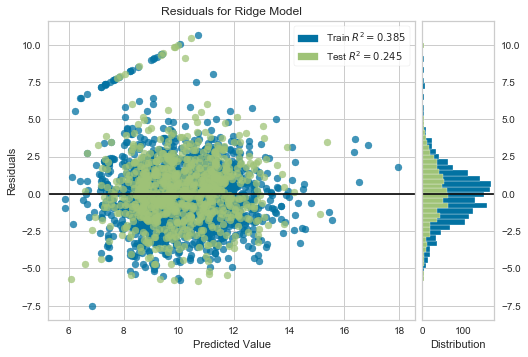

{'alpha': 3.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [38]:
# Instantiate the linear model and visualizer
model = Ridge(alpha=3.0, fit_intercept=True, max_iter=None, normalize=False, solver='auto', tol=0.001)

visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof()             # Draw/show/poof the data

model.get_params()

In [39]:
# reduce optimaly the dimensionnality of a model (1.13. Feature selection) ==> solution for overfitting in Ridge
modela = SelectFromModel(model, prefit=True)
X_new = modela.transform(X)
X_new.shape

(2790, 105)

As a reminder, R² formula:
$$ R^2 = 1 - \frac{Sum of Squares of Residuals}{Total Sum of Squares} = 1 - \frac{\sum_i ( y_i - f_i )^2}{\sum_i (y_i - \bar{y})^2}$$

As per this graph, Ridge model or any linear model won't correctly fit our data. The huge difference of R² between train and test sets indicates the Ridge model is over-fitting
Neither linear nor polynomial model seem adapted to modelize this dataset; we propose to use bagging methodology to try to get better estimated values

Use of (Bagging) meta-estimators

The KNeighborsRegressor or random forest regressor use kNN or decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

### K-Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [40]:
# Model creation and fit
model1 = BaggingRegressor(KNeighborsRegressor(n_neighbors=15, weights='distance'))
model1.fit(X_train,y_train)

# Show model results of training set
y2_hat = model1.predict(X_train)
mae = metrics.mean_absolute_error(y_train,y2_hat)
mse = metrics.mean_squared_error(y_train,y2_hat)
print ("TRAINING SET")
print ("=========================================")
print ("MAE:         ", mae)
print ("MSE:         ", math.sqrt(mse))
print ("r2:          ", model1.score(X_train,y_train))
print ("n_features:  ", model1.n_features_)

# Show model results of test set
y_hat_test = model1.predict(X_test)
mae = metrics.mean_absolute_error(y_test,y_hat_test)
mse = metrics.mean_squared_error(y_test,y_hat_test)
print ("\nTEST SET")
print ("=========================================")
print ("MAE:                ", mae)
print ("RMSE:               ", math.sqrt(mse))
print ("r2:                 ", model1.score(X_test,y_test))
print ("r2 retry:           ", r2_score(y_test, y_hat_test))
print ("n_features:         ", model1.n_features_)

model1.get_params()

TRAINING SET
MAE:          0.6230456555393927
MSE:          0.9151032481716002
r2:           0.8786674070345014
n_features:   278

TEST SET
MAE:                 1.612061294118154
RMSE:                2.206436225457331
r2:                  0.24615585306812404
r2 retry:            0.24615585306812404
n_features:          278


{'base_estimator__algorithm': 'auto',
 'base_estimator__leaf_size': 30,
 'base_estimator__metric': 'minkowski',
 'base_estimator__metric_params': None,
 'base_estimator__n_jobs': None,
 'base_estimator__n_neighbors': 15,
 'base_estimator__p': 2,
 'base_estimator__weights': 'distance',
 'base_estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='distance'),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### AdaBoost

In [41]:
model2 = AdaBoostRegressor(n_estimators=100)
scores = cross_val_score(model2, X, y, cv=10) # Cross-Validation
scores.mean() 

0.2202013487815741

### Random Forest Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [42]:
# Model creation and fit
model3 = RandomForestRegressor(max_depth=3, criterion='mse', n_estimators=100)
model3.fit(X_train,y_train)

# Show model results of training set
y2_hat = model3.predict(X_train)
mae = metrics.mean_absolute_error(y_train,y2_hat)
mse = metrics.mean_squared_error(y_train,y2_hat)
mse_allfeatures = mse
print ("TRAINING SET")
print ("=========================================")
print ("MAE:                ", mae)
print ("MSE:                ", math.sqrt(mse))
print ("r2:                 ", model3.score(X_train,y_train))
print ("n_features:         ", model3.n_features_)
print ("n_outputs:          ", model3.n_outputs_)

# Show model results of test set
y_hat_test = model3.predict(X_test)
mae = metrics.mean_absolute_error(y_test,y_hat_test)
mse = metrics.mean_squared_error(y_test,y_hat_test)
print ("\nTEST SET")
print ("=========================================")
print ("MAE:                ", mae)
print ("RMSE:               ", math.sqrt(mse))
print ("r2:                 ", model3.score(X_test,y_test))
print ("r2 retry:           ", r2_score(y_test, y_hat_test))
print ("n_features:         ", model3.n_features_)
print ("n_outputs:          ", model3.n_outputs_)

TRAINING SET
MAE:                 1.5838953994756324
MSE:                 2.171638626462117
r2:                  0.3166984582752783
n_features:          278
n_outputs:           1

TEST SET
MAE:                 1.507976227088831
RMSE:                2.0983287901911805
r2:                  0.31821744014163844
r2 retry:            0.31821744014163844
n_features:          278
n_outputs:           1


#### Feature Selection

We calculate feature importance by measuring how much MSE is increased if we remove one of the features in turn.

In [43]:
features = [col for col in df_selected2.columns]
features.remove('All Costs')
features.remove('Log All Costs')
columns = [col for col in newdf.columns]
columns.remove('All Costs')
columns.remove('Log All Costs')

In [44]:
# Identify sets of columns to be deleted for each feature
import re
dic = {}
for feat in features:
    l = []
    for col in columns:
        exists = re.search(feat, col)
        if exists:
            l.append(col)
    if not l:  # If the list is empty
        dic[feat] = [feat]
    else:
        dic[feat] = l

In [45]:
# Run Random Forest on the training set without one of the features in turn,
# and calculate the gap (i.e. importance) between the MSE on such training set and
# the MSE on the training set with all the features
importance = []
for feat in features:
    X_train_ = X_train.copy()
    for col in dic[feat]:
        X_train_ = X_train_.drop(col, axis=1)
    model3_ = RandomForestRegressor(max_depth=3, criterion='mse', n_estimators=100)
    model3_.fit(X_train_, y_train)
    y2_hat_ = model3_.predict(X_train_)
    mse_ = metrics.mean_squared_error(y_train, y2_hat_)
    importance.append((feat, mse_ - mse_allfeatures))

# Sort the importance
criteria = lambda e: e[1]
importance.sort(key=criteria, reverse=True)

for i in range(len(importance)):
    print(importance[i])

('Shutdown Duration', 0.21619044526090914)
('Pipeline Type', 0.20204251538791507)
('Net Loss (Barrels)', 0.12726253132663068)
('Liquid Type', 0.07666443863060479)
('Operator ID', 0.015422374897027247)
('Accident Year', 0.010600336842742308)
('Accident State', 0.0019518208528115366)
('Accident Latitude', 0.0005925111492617319)
('Cause Category', -0.00010233835274497949)
('Liquid Ignition', -0.0009305940860793172)
('Accident Longitude', -0.003442862375846012)
('Liquid Explosion', -0.010950073714949049)


- From the above result, we found that 'Net Loss (Barrels)' is the most important feature when predicting the cost, followed by 'Pipeline Type' or 'Shutdown Duration'.

## Conclusion

Meta estimator such as randomforestRegressor are much more efficient and accurate than simple regressor models. With a R² higher than 80%, far ahead of linear regression models, it allows acceptable cost prediction of pipeline accident.

Regarding Random Forest, I tried prediction without Operator IDs and found its R^2 was 0.69 for both train and test data. If dummy variable trap does not chage the result, we could argue that the amount of cost is correlated with Operators. We can also draw an analogy between this and our preliminary analysis above (that the total yearly cost has been continuously decreasing) saying that cost depends on how operators deal with accidents, whose skill depends on each operator and has been improving over the years.